In [1]:
# change to parent directory to import module
%cd ..

/home/achilleas/projects/osbuild/metrics


In [2]:
import json
import pandas
import report

import numpy as np
import matplotlib.pyplot as plt
import ibmetrics as ib

from datetime import datetime, timedelta

from IPython.display import display, Markdown

builds = report.read_file("./data/dump-2022-10-03.log")
users = pandas.read_json("./data/userinfo.json")

def mdprint(msg):
    display(Markdown(msg))

mdprint(f"Read {len(builds)} records")

# remove builds before Image builder GA
ga_date = datetime(2022, 5, 4)
ga_idxs = builds["created_at"] >= ga_date
builds = builds.loc[ga_idxs]
mdprint(f"Using {len(builds)} records (since GA)")

Using cached pickle file at /home/achilleas/.cache/osbuild-metrics/dump-2022-10-03.pkl


Read 5995 records

Using 4161 records (since GA)

In [3]:
users = pandas.read_json("./data/userinfo.json")
with open("./data/userfilter.txt", encoding="utf-8") as filterfile:
    user_filter = filterfile.read().split("\n")
builds = ib.data.filter_users(builds, users, user_filter)
mdprint(f"Using {len(builds)} records (after filtering)")

Using 1734 records (after filtering)

In [4]:
summary = ib.metrics.make_summary(builds)
mdprint(ib.metrics.summarise(summary))

Summary
=======

Period: 2022-05-04 14:11:47.137615 - 2022-10-01 17:28:48.708682

- Total builds: 1734
- Number of users: 671
- Builds with packages: 993
- Builds with filesystem customizations: 608
- Builds with custom repos: 21

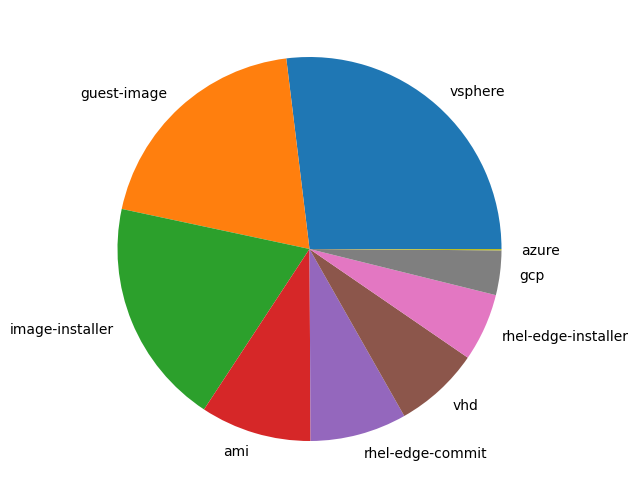

In [5]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.image_types(builds, ax)

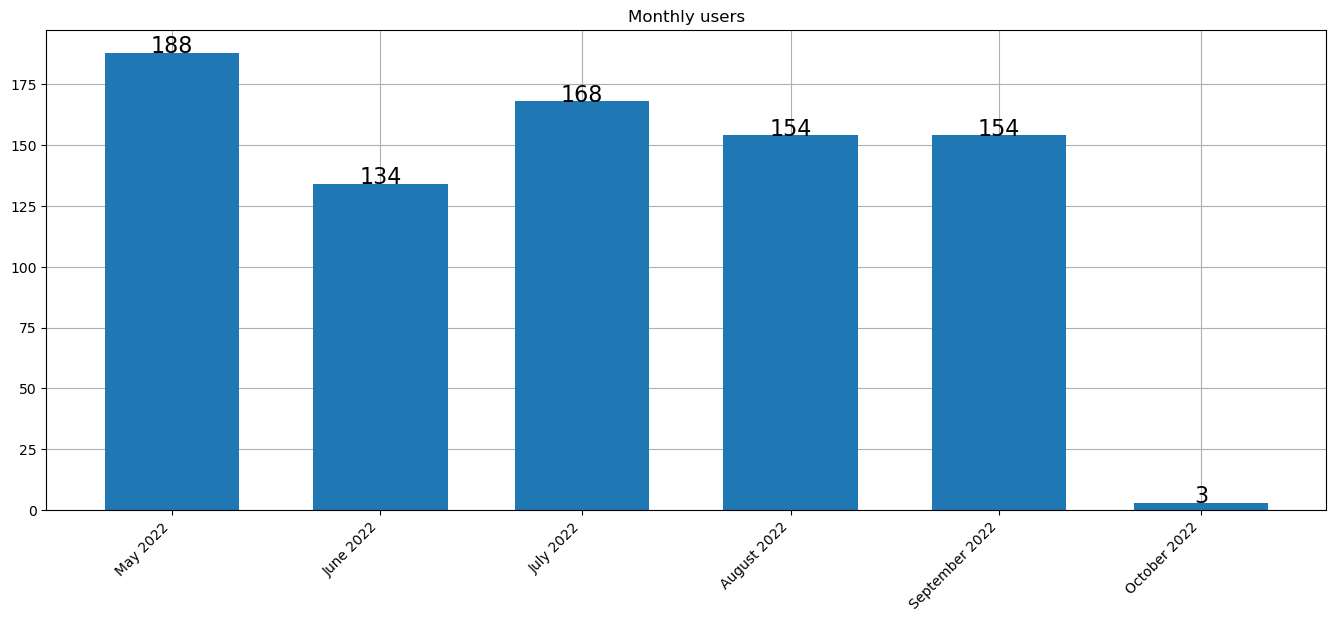

In [6]:
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

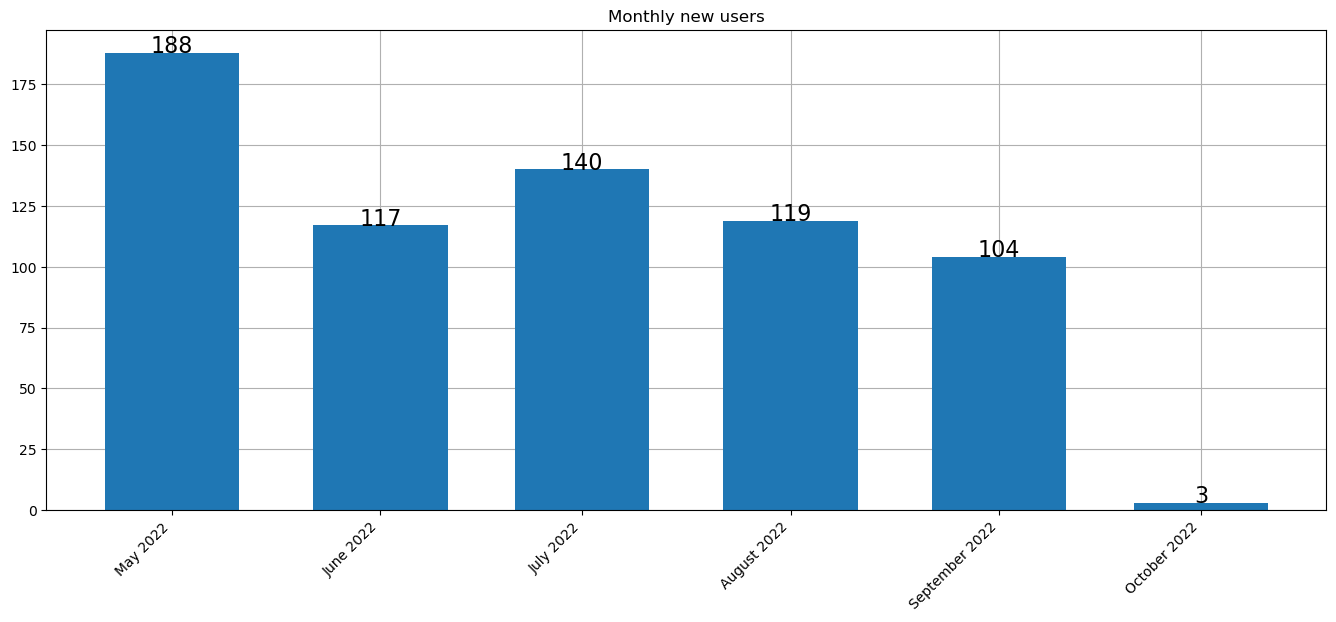

In [7]:
fig = plt.figure()
new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

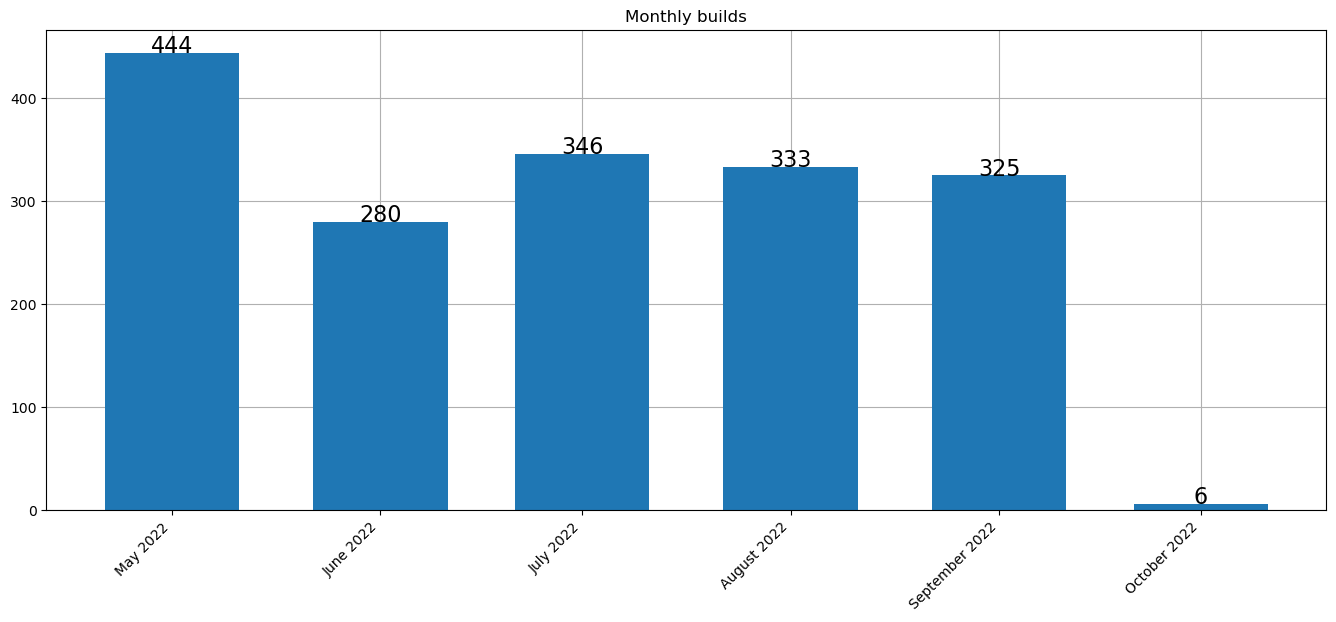

In [8]:
fig = plt.figure()
builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)

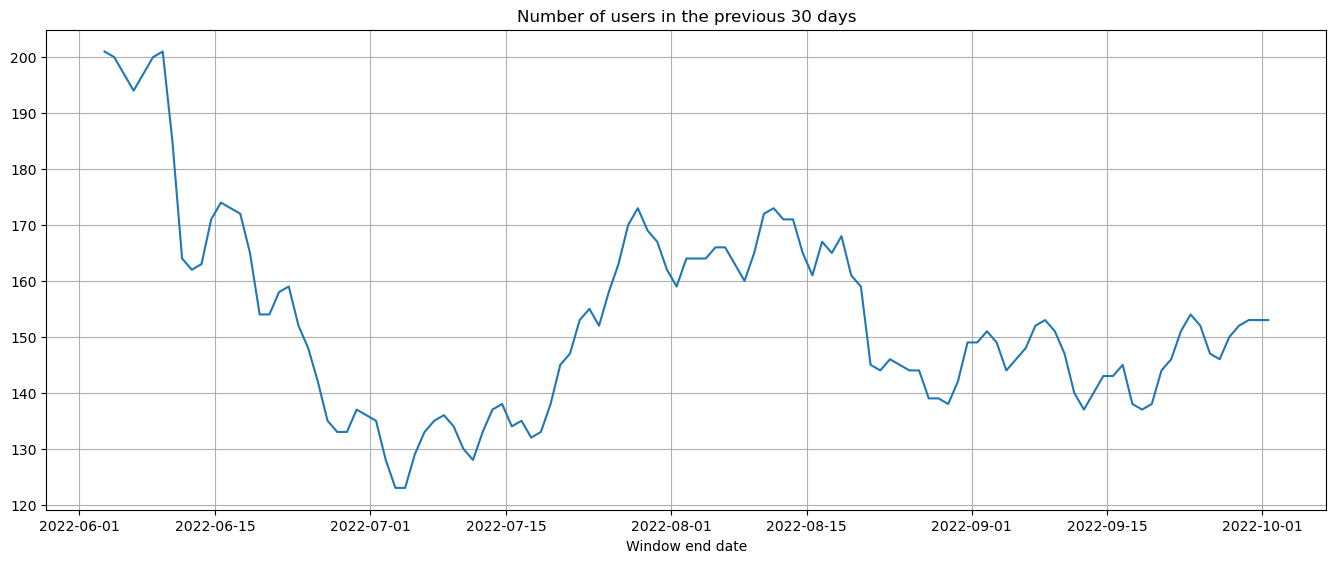

In [9]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 1])
ib.plot.users_sliding_window(builds, ax)

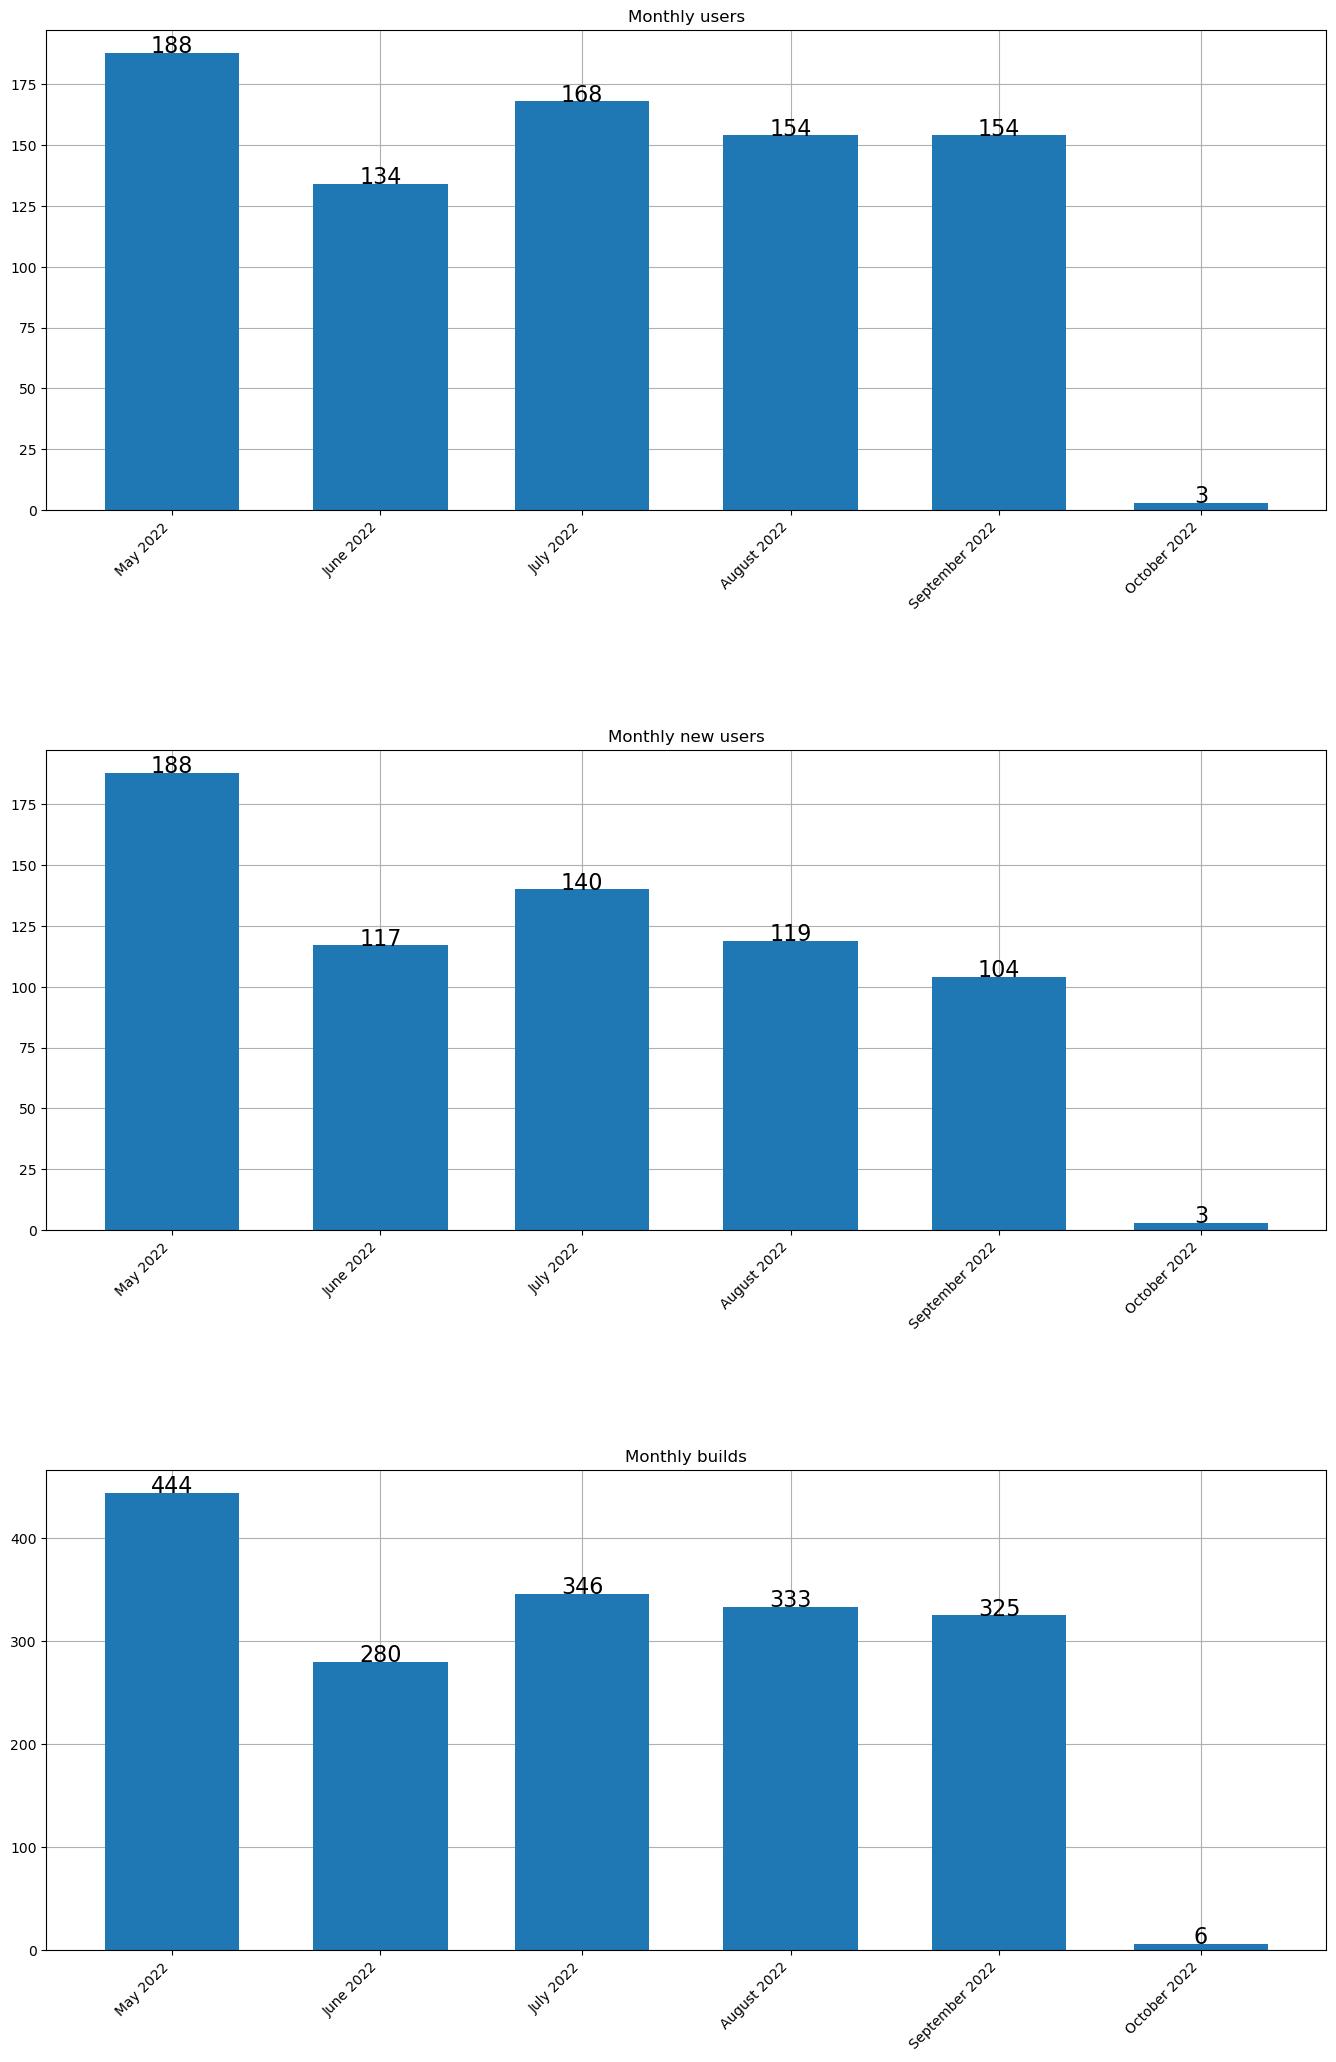

In [10]:
# draw bar graphs again on one figure for convenience
fig = plt.figure()
users_ax = fig.add_axes([0, 3, 2, 1])
ib.plot.monthly_users(builds, users_ax)

new_users_ax = fig.add_axes([0, 1.5, 2, 1])
ib.plot.monthly_new_users(builds, new_users_ax)

builds_ax = fig.add_axes([0, 0, 2, 1])
ib.plot.monthly_builds(builds, builds_ax)